In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

In [15]:
df = pd.read_csv("forecasting_data.csv")
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


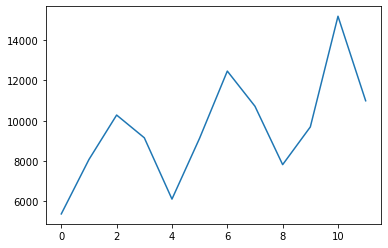

In [16]:
#visualize 
plt.plot(df["Sales"])
plt.show()

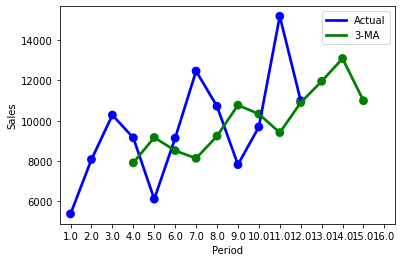

In [17]:
#using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns = ['Period','Sales'])
    for m in range(0, to_period):
        if m < k:
            prediction = float("nan")
        else:
            history = df["Sales"][m-k:m]
            prediction = history.mean()
        moving_average_df.loc[m] = [m+1, prediction]
    return moving_average_df 
    
f, ax = plt.subplots(1,1 )
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y = 'Sales', data=df, color='b')
sns.pointplot(x='Period', y = 'Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()
          

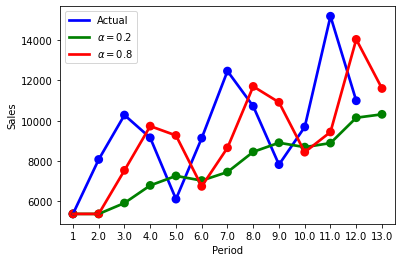

In [18]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1, df['Sales'][0]]
    num_df = len(df)
    for m in range (0, num_df):
        prediction = alpha * df["Sales"][m] + (1 - alpha) * es_df["Sales"][m]
        es_df.loc[m+1] = [m+2, prediction]
    return es_df

f, ax = plt.subplots(1,1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()                              

         I     II    III
Seq                     
1     5384   6118   7825
2     8081   9139   9693
3    10282  12460  15177
4     9156  10717  10990
I       8225.75
II      9608.50
III    10921.25
dtype: float64
            I        II       III       Avg
Seq                                        
1    0.654530  0.560337  0.492984  0.569284
2    0.982403  0.841026  0.739934  0.854454
3    1.249977  1.070094  0.941467  1.087180
4    1.113090  0.952906  0.838366  0.968121
12038.807805355975


/var/folders/5n/x_95j7x91xv3xxr2176lphzm0000gn/T/ipykernel_8751/4264178298.py:47: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


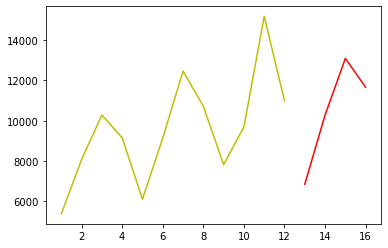

In [19]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row["Period"] <=8:
        return 'II'
    elif row["Period"] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
    
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis =1)
    
    print(season_df)
    
    avg_df = season_df.apply(np.mean)
    print(avg_df)
    
    seasonal_index_df = pd.DataFrame(columns = ['I', 'II', 'III'])
    seasonal_index_df['I'] = season_df["I"]/avg_df["I"]
    seasonal_index_df['II'] = season_df["I"]/avg_df["II"]
    seasonal_index_df['III'] = season_df["I"]/avg_df["III"]
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1)
    print(seasonal_index_df)
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    print(average_predict)
    
    forecast_df = pd.DataFrame(columns=['Period', 'Sales'])
    forecast_df['Sales'] = seasonal_index_df["Avg"]*average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')

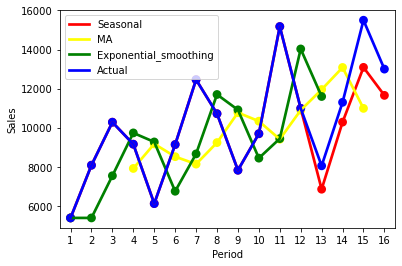

In [20]:
#4.Evaluation:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index = True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='blue')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", "MA", "Exponential_smoothing", "Actual"])
plt.show()

In [22]:
MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("exponential smoothing with alpha=0.8", MAD))
season2_df = predict_with_seasonality(df, [13,14,15,16])
MAD = np.absolute(eval_df["Sales"][12:16] - season2_df["Sales"]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of exponential smoothing with alpha=0.8: 3088.7232615120074
         I     II    III
Seq                     
1     5384   6118   7825
2     8081   9139   9693
3    10282  12460  15177
4     9156  10717  10990
I       8225.75
II      9608.50
III    10921.25
dtype: float64
            I        II       III       Avg
Seq                                        
1    0.654530  0.560337  0.492984  0.569284
2    0.982403  0.841026  0.739934  0.854454
3    1.249977  1.070094  0.941467  1.087180
4    1.113090  0.952906  0.838366  0.968121
12038.807805355975
MAD of Seasonality Method: 1491.632325423452


/var/folders/5n/x_95j7x91xv3xxr2176lphzm0000gn/T/ipykernel_8751/2568925930.py:7: RankWarning: Polyfit may be poorly conditioned
  season2_df = predict_with_seasonality(df, [13,14,15,16])


In [31]:
MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))

MSE of 3-MA: 11544241.36111111


In [33]:
MSE = (eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.2)["Sales"][12:16]**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))

SyntaxError: invalid syntax (631748855.py, line 2)

In [29]:
MSE = (eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.8)["Sales"][12:16]**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = (eval_df["Sales"][12:16] - predict_with_seasonality(eval_df, [13,14,15,16])["Sales"][12:16])**2
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

SyntaxError: invalid syntax (1143141275.py, line 2)